In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch
from transformers import BertTokenizer, BertForMaskedLM
from transformers import AdamW
from tqdm import tqdm

#from google.colab import drive
#drive.mount('/content/drive')

### Big Query Integration:
```
%%bigquery morningroutinelab --project Cancer-Causal
WITH cohort AS (
  SELECT
    hadm_id,
    subject_id,
    itemid,
    charttime,
    EXTRACT(HOUR FROM charttime) AS charthour,
    storetime,
    EXTRACT(HOUR FROM storetime) AS storehour,
    EXTRACT(DATE FROM charttime) AS chartday,
    valuenum
  FROM
    `physionet-data.mimiciv_hosp.labevents`
  WHERE EXTRACT(HOUR FROM charttime) BETWEEN 5 AND 8
    AND itemid IN (50912, 51265, 51222, 51301, 51006, 50983, 50882, 50971)
),
patdailycnt AS (
  SELECT
    subject_id,
    chartday,
    COUNT(DISTINCT itemid) AS cnt
  FROM cohort where SAFE_CAST(valuenum AS FLOAT64) IS NOT NULL AND valuenum IS NOT NULL
  GROUP BY subject_id, chartday
)
  SELECT cohort.*,patdailycnt.cnt
  FROM cohort
  RIGHT JOIN patdailycnt
  ON cohort.subject_id = patdailycnt.subject_id AND cohort.chartday = patdailycnt.chartday
  WHERE patdailycnt.cnt = 8
  ```

In [2]:
### I'll read the dataset froma csv file
#%cd '/content/drive/MyDrive/lab_values'
FILE = 'morningroutinelab.csv'

morningroutinelab = pd.read_csv(FILE)

In [3]:
morningroutinelab.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,10312413,51222,2173-06-05 08:20:00,8,2173-06-05 08:47:00,8,2173-06-05,12.8,8
1,25669789.0,10390828,51222,2181-10-26 07:55:00,7,2181-10-26 08:46:00,8,2181-10-26,9.4,8
2,26646522.0,10447634,51222,2165-03-07 06:55:00,6,2165-03-07 07:23:00,7,2165-03-07,11.1,8
3,27308928.0,10784877,51222,2170-05-11 06:00:00,6,2170-05-11 06:43:00,6,2170-05-11,10.3,8
4,28740988.0,11298819,51222,2142-09-13 07:15:00,7,2142-09-13 09:23:00,9,2142-09-13,10.2,8


### Preprocessing

In [4]:
mrl_sorted = morningroutinelab.sort_values(by=['subject_id', 'hadm_id', 'chartday', 'itemid', 'charthour'])
mrl_sampled = mrl_sorted.groupby(['subject_id', 'hadm_id', 'chartday', 'itemid']).first().reset_index()
mrl_full = mrl_sampled.pivot(index=['subject_id', 'hadm_id', 'chartday'], columns='itemid', values='valuenum').reset_index()
mrl = mrl_full.dropna()
mrl = mrl.rename(columns={50882: 'Bic', 50912: 'Crt', 50971: 'Pot', 50983: 'Sod', 51006: 'Ure', 51222: 'Hgb', 51265: 'Plt', 51301: 'Wbc'})
columns_to_scale = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Scale selected columns
mrl[columns_to_scale] = scaler.fit_transform(mrl[columns_to_scale])

In [5]:
mrl.head()

itemid,subject_id,hadm_id,chartday,Bic,Crt,Pot,Sod,Ure,Hgb,Plt,Wbc
0,10000935,26381316.0,2187-08-25,0.463415,0.019417,0.217949,0.500000,0.044304,0.254902,0.318553,0.048686
1,10000980,25242409.0,2191-04-05,0.414634,0.111650,0.256410,0.739130,0.594937,0.385621,0.065344,0.015491
2,10001401,21544441.0,2131-06-06,0.487805,0.029126,0.282051,0.521739,0.107595,0.464052,0.126021,0.029876
4,10001884,26170293.0,2130-04-17,0.487805,0.033981,0.217949,0.543478,0.056962,0.581699,0.122520,0.015214
6,10004235,22187210.0,2196-06-21,0.365854,0.058252,0.256410,0.456522,0.056962,0.326797,0.137690,0.037068


### Encode Numbers -> Text

In [6]:
def int_to_letters(number):
    result = ""
    while number >= 0:
        number, remainder = divmod(number, 26)
        result = chr(65 + remainder) + result
        if number == 0:
            break
        number -= 1  # Adjust for 0-based indexing
    return result

# Generate letters for numbers from 0 to 99
letters_mapping = {i: int_to_letters(i) for i in range(101)}
def scale_to_letter(value):
    return letters_mapping[int(value * 100)]

mrl['nstr'] = mrl[columns_to_scale].apply(lambda row: ' '.join(f'{col}{scale_to_letter(val)}' for col, val in zip(columns_to_scale, row)), axis=1)
grouped_mrl = mrl.groupby('hadm_id')['nstr'].apply(list).reset_index()

In [7]:
grouped_mrl

,hadm_id,nstr
0,20000235.0,[BicAR CrtU PotY SodAI UreV HgbAE PltB WbcA]
1,20004357.0,[BicBE CrtD PotAG SodBA UreL HgbAE PltP WbcC]
2,20005361.0,[BicAU CrtE PotAC SodBP UreL HgbAE PltK WbcB]
3,20005721.0,[BicAI CrtA PotZ SodAR UreB HgbAG PltR WbcB]
4,20007831.0,[BicBG CrtE PotAE SodAY UreP HgbZ PltT WbcE]
...,...,...
8555,29991539.0,[BicAP CrtI PotV SodBI UreS HgbAI PltN WbcD]
8556,29995410.0,[BicAU CrtD PotV SodAP UreF HgbAJ PltG WbcA]
8557,29997206.0,[BicAR CrtC PotAL SodAY UreC HgbAG PltP WbcD]
8558,29998928.0,[BicAR CrtF PotAG SodAK UreO HgbAV PltS WbcC]


### Tokenize

In [8]:
from transformers import BertTokenizer

# Insert special tokens into the list
def insert_special_tokens(input_list, special_tokens):
    result_list = input_list.copy()
    for position, token in special_tokens.items():
        result_list.insert(position, token)
    return result_list

# Create a vocab.txt file
def create_vocab_file(vocab_list, vocab_file_path):
    with open(vocab_file_path, 'w', encoding='utf-8') as vocab_file:
        for token in vocab_list:
            vocab_file.write(token + '\n')

# Create a BERT tokenizer
def create_bert_tokenizer(vocab_file_path):
    tokenizer = BertTokenizer(vocab_file_path, do_lower_case=False)
    return tokenizer

In [21]:
vocab_list = mrl['nstr'].str.split(' ').explode().unique().tolist()
special_tokens = {0: '[PAD]', 101: '[CLS]', 102: '[SEP]', 103: '[MASK]'}

# Insert special tokens into the list
modified_vocab = insert_special_tokens(vocab_list, special_tokens)

In [27]:
# Create a vocab.txt file
vocab_file_path = 'vocab.txt'
create_vocab_file(modified_vocab, vocab_file_path)

In [28]:
# Create a BERT tokenizer
tokenizer = create_bert_tokenizer(vocab_file_path)

In [29]:
len(tokenizer)

496

In [31]:
text = grouped_mrl['nstr'].apply(lambda x: ' [SEP] '.join(x)).tolist()

In [32]:
def random_train_test_split(data, train_percent=.8):
    # Randomly split data into training and test sets.
    np.random.seed(42)
    data = np.array(data)
    np.random.shuffle(data)
    train_size = int(len(data) * train_percent)
    train = data[:train_size]
    test = data[train_size:]
    # Convert to list
    train = train.tolist()
    test = test.tolist()
    return train, test

train, test = random_train_test_split(text)

In [33]:
train_inputs = tokenizer(train, return_tensors='pt', max_length=100, truncation=True, padding='max_length')

test_inputs = tokenizer(test, return_tensors='pt', max_length=100, truncation=True, padding='max_length')

### Dataset Perparation

In [34]:
train_inputs['labels'] = train_inputs.input_ids.detach().clone()
test_inputs['labels'] = test_inputs.input_ids.detach().clone()

In [35]:
train_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

Model Masked Language Model (MLM):

Pretraining method: The idea is to mask some words (lab values) so the model use the rest of the values to predict the missing values. That way the model will learn the relations between the lab values.

To pre-train the model we'll need to mask some values randomly. In this case 20%. We will ignore the tokens CLS (101), SEP (102) and PAD (0).

In [36]:
# List of token IDs
token_ids = [101, 102, 0]

# Decode token IDs to get corresponding values
decoded_values = tokenizer.decode(token_ids)

print(decoded_values)

[CLS] [SEP] [PAD]


In [37]:
def randomly_mask_dataset(inputs, parcentage=0.20, CLS=101, SEP=102, PAD=0):

    # create random array of floats with equal dimensions to input_ids tensor
    rand = torch.rand(inputs.input_ids.shape)
    # Create mask array
    mask_arr = (rand < parcentage) * (inputs.input_ids != CLS) * (inputs.input_ids != SEP) * (inputs.input_ids != PAD)

    # Take the index of each masked token and replace with the token 103
    masked = []

    for i in range(inputs.input_ids.shape[0]):
        masked.append(torch.flatten(mask_arr[i].nonzero()).tolist())

    for i in range(inputs.input_ids.shape[0]):
        inputs.input_ids[i, masked[i]] = 103

    return inputs

In [38]:
MASKING = 0.20

train_inputs = randomly_mask_dataset(train_inputs, parcentage=MASKING)
test_inputs = randomly_mask_dataset(test_inputs, parcentage=MASKING)

In [39]:
train_inputs.input_ids

tensor([[101,  40, 103,  ...,   0,   0,   0],
        [101, 103,  18,  ...,   0,   0,   0],
        [101, 160, 103,  ...,   0,   0,   0],
        ...,
        [101,  51, 103,  ...,   0,   0,   0],
        [101, 160,  25,  ...,   0,   0,   0],
        [101, 108, 103,  ...,   0,   0,   0]])

### Dataleader

In [40]:
class LabValuesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [41]:
train_dataset = LabValuesDataset(train_inputs)
test_dataset = LabValuesDataset(test_inputs)

In [42]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

### Model

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Apple slilicon:
device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu')

In [44]:
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.resize_token_embeddings(len(tokenizer))
# and move our model over to the selected device
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(496, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

### Training

In [45]:
# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)

/Users/davidrestrepo/miniforge3/envs/labrador/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/428 [00:00<?, ?it/s]/var/folders/4w/k6c16td51cv9ytcmnnvx3mpw0000gn/T/ipykernel_94955/302765012.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1 (Eval): 100%|██████████| 107/107 [01:03<00:00,  1.68it/s, loss=0.0608]


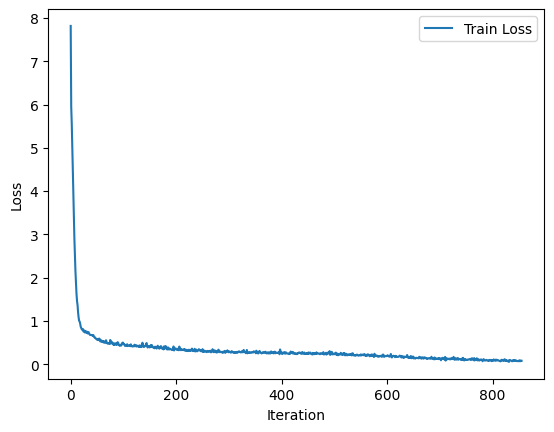

In [46]:
epochs = 2
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    train_loop = tqdm(train_loader, leave=True)
    for batch in train_loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()
        train_losses.append(loss.item())
        train_loop.set_description(f'Epoch {epoch}')
        train_loop.set_postfix(loss=loss.item())

    # Evaluation
    model.eval()
    test_loop = tqdm(test_loader, leave=True)
    for batch in test_loop:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_losses.append(loss.item())
            test_loop.set_description(f'Epoch {epoch} (Eval)')
            test_loop.set_postfix(loss=loss.item())


model.save_pretrained("model/")
tokenizer.save_pretrained("tokenizer/")

# Plotting
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Load the model

In [47]:
from transformers import BertForMaskedLM, BertTokenizer

# Load the saved model and tokenizer
model = BertForMaskedLM.from_pretrained("model/")
tokenizer = BertTokenizer.from_pretrained("tokenizer/")

### Get Embeddings

In [48]:
def get_embeddings(model, tokenizer, texts):

    model.eval()
    
    # Tokenize and convert the input texts to tensors
    tokens = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    
    # Forward pass to obtain the embeddings
    with torch.no_grad():
        embeddings = model(**tokens, output_hidden_states=True, return_dict=True)

    # Extract the embeddings from the last hidden state
    embeddings = np.array(embeddings.hidden_states[-1])

    return embeddings

In [49]:
texts_to_embed = ["This is a sample sentence.", "Another example for embeddings."]

embeddings = get_embeddings(model, tokenizer, texts_to_embed)
print("Embeddings Shape:", embeddings.shape)
print(embeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Embeddings Shape: (2, 8, 768)
[[[-0.49939942 -0.3252505  -0.30454722 ...  0.1831341   0.15631016
    0.0508475 ]
  [ 0.8420637   0.7331135   0.06322432 ...  0.7596819  -0.72309816
    0.1683993 ]
  [ 0.67765754  0.35475954  0.45529342 ...  0.9190105  -0.93369794
   -0.20882437]
  ...
  [ 1.2109077  -0.23138356 -0.23602165 ...  0.7183799  -0.9758155
   -0.19742072]
  [ 1.7765887   0.2612248   0.46532738 ...  0.59862673 -0.70830154
   -0.81637096]
  [ 0.369804   -0.38128763 -0.47079998 ...  1.0526273  -0.24447265
   -0.499013  ]]

 [[-0.49586958 -0.35578215 -0.32065305 ...  0.24539039  0.20613106
    0.04686604]
  [ 0.8305602   0.7563559   0.05792234 ...  0.77873474 -0.75425863
    0.15379828]
  [ 0.6755165   0.35896558  0.43717715 ...  1.0163783  -0.9384985
   -0.26118717]
  ...
  [ 1.3808904  -0.11981761 -0.27989095 ...  0.5025964  -0.7696203
   -0.59993446]
  [ 0.39476097 -0.4111559  -0.50136316 ...  1.0499966  -0.22167918
   -0.49201792]
  [ 0.76907027  0.52228135  1.4269865  ... -0.